# [drosophila_body_orientation_predictor](https://github.com/nehalsinghmangat/drosophila_body_orientation_predictor)  Notebook
This notebook serves to clean, correct, and augment the experimental data described in the paper [Plume-Tracking Behavior of Flying Drosophila Emerges from a Set of Distinct Sensory-Motor Reflexes (F. van Breugel et al., 2014)](https://www.sciencedirect.com/science/article/pii/S0960982213015820) in order to generate a neurel network capable of predicting the heading of a fly over its trajectory. This is an in-house neurel net for predicting the heading for specific trajectory data; further generalization will require additional work.

## Generate Training Data

### Generate Raw Heading-and-Trajectory Data
The experimental data was collected in three constant-wind conditions: 30cm/s, 40 cm/s, and 60 cm/s. For each windspeed, there are three data sets: flight trajectory, body orientation, and a key table matching the fly ids between the two. As we wish to generate training data for a neurel net that can predict the body orientation (heading) of a fly over its trajectory, it is necessary to first merge all three data sets into one heading-and-trajectory dataset for each windspeed, and then merge all of the windspeeds into a large training set. This is implemented below.

In [1]:
import pandas as pd
import datetime

windspeeds = ["30cms", "40cms", "60cms"] # iterate over all three windspeeds
for windspeed in windspeeds:
    # import hdf5 files 
    trajec_df = pd.read_hdf(f"../ExperimentalData/{windspeed}/flight_trajectories_3d_HCS_odor_horizon_matched.h5")
    body_df = pd.read_hdf(f"../ExperimentalData/{windspeed}/body_orientations_HCS_odor_horizon_matched.h5")
    key_table = pd.read_hdf(f"../ExperimentalData/{windspeed}/body_trajec_matches.h5")

    # correct for constant wind in trajectory df so airspeed is relative to the wind
    def correct_for_wind(trajec_df: pd.DataFrame) -> pd.DataFrame:
        corrected_trajectory_df = trajec_df.copy()
        corrected_trajectory_df["airvelocity_x"] = corrected_trajectory_df["airvelocity_x"] - 2 * corrected_trajectory_df[
            "wind_speed"]
        return corrected_trajectory_df
    
    trajec_df = correct_for_wind(trajec_df)

    # remove fields not required for our analysis
    def remove_irrelevant_trajectory_data(trajec_df: pd.DataFrame) -> pd.DataFrame:
        trimmed_trajec_df = trajec_df.copy()
        trimmed_trajec_df = trimmed_trajec_df.drop(
            ["course", "frame", "odor", "odor_stimulus", "position_z", "velocity_z",
            "groundspeed_xy", "airspeed_xy"], axis=1)
        trimmed_and_reordered_trajec_df = trimmed_trajec_df[['objid', 'timestamp', 'position_x', 'position_y',
                                                            'velocity_x', 'velocity_y', 'airvelocity_x', 'airvelocity_y',"wind_speed","wind_direction"]]
        trimmed_and_reordered_trajec_df = trimmed_and_reordered_trajec_df.rename(columns={'objid': 'trajec_objid',"wind_speed":'windspeed','wind_direction':'windspeed_angle'})
        return trimmed_and_reordered_trajec_df
    
    trajec_df = remove_irrelevant_trajectory_data(trajec_df)
    
    # remove fields not required for our analysis
    def remove_irrelevant_body_data(body_df: pd.DataFrame) -> pd.DataFrame:
        trimmed_body_df = body_df.copy()
        trimmed_body_df = trimmed_body_df.drop(["date", "frame", "longaxis_0", "longaxis_1", "position_x", "position_y"],
                                            axis=1)
        trimmed_and_reordered_body_df = trimmed_body_df[['body_objid', 'timestamp', 'eccentricity', 'angle']]
        trimmed_and_reordered_body_df = trimmed_and_reordered_body_df.rename(columns={'angle':'ellipse_short_angle'})
        return trimmed_and_reordered_body_df
    
    body_df = remove_irrelevant_body_data(body_df)

    # synchronize timestamps from dataframes via rounding each timestamp to two decimal places so that the dataframes can be merged later
    def sync_time(df: pd.DataFrame) -> pd.DataFrame:
        df_synced = df.copy()
        df_synced['timestamp'] = df['timestamp'].apply(
            lambda x: int(datetime.datetime.utcfromtimestamp(x).strftime('%S')) +
                    float(datetime.datetime.utcfromtimestamp(x).strftime('%f')[0:2]) / 100)
        return df_synced
    
    synced_trajectory = sync_time(trajec_df)
    synced_body = sync_time(body_df)

    # merge the trajectory and body dataframes
    def join_all_body_and_trajec_df(synced_body: pd.DataFrame, synced_trajectory: pd.DataFrame, key_table: pd.DataFrame) -> list[pd.DataFrame]:
        
        def join_body_and_trajec_on_id(synced_body, synced_trajectory, key_table, trajec_id):
            fly_trajectory = synced_trajectory[synced_trajectory['trajec_objid'] == trajec_id]
            body_id = key_table[key_table['trajec_objid'] == trajec_id]['body_objid'].values[0]
            fly_body = synced_body[synced_body['body_objid'] == body_id]
            fly_trajectory_and_body = pd.merge(fly_trajectory,fly_body,on='timestamp',how='inner').drop(['body_objid'],axis=1)
            return fly_trajectory_and_body
        
        ids = synced_trajectory['trajec_objid'].unique()
        all_flies_body_and_trajectory = []
        for trajec_objid in ids:
            fly_trajectory_and_body = join_body_and_trajec_on_id(synced_body, synced_trajectory, key_table, trajec_objid)
            all_flies_body_and_trajectory.append(fly_trajectory_and_body)
        return all_flies_body_and_trajectory

    body_and_trajectory = join_all_body_and_trajec_df(synced_body, synced_trajectory, key_table)
    
    # start each merged dataframe at 0, for consistency
    def transform_timestamps_to_start_at_zero(fly_trajectory_and_body: pd.DataFrame) -> pd.DataFrame:
        fly_trajectory_and_body["timestamp"] = fly_trajectory_and_body["timestamp"] - fly_trajectory_and_body["timestamp"][0]
        return fly_trajectory_and_body

    body_and_trajectory = [transform_timestamps_to_start_at_zero(fly_trajectory) for fly_trajectory in body_and_trajectory] 

    # filter trajectories based on length
    body_and_trajectory = [fly_trajectory for fly_trajectory in body_and_trajectory if len(fly_trajectory) > 12]
    
    # concatenate all dataframes vertically and write to csv
    temp_fly_data = pd.concat(body_and_trajectory, ignore_index=True)
    temp_fly_data.to_csv(f"../ExperimentalData/{windspeed}/fly_trajectories_with_body_orientations.csv",index=False)

# Read and concatenate all CSV files
temp_file_paths = ["../ExperimentalData/30cms/fly_trajectories_with_body_orientations.csv",
              "../ExperimentalData/40cms/fly_trajectories_with_body_orientations.csv",
              "../ExperimentalData/60cms/fly_trajectories_with_body_orientations.csv"]
temp_dfs = [pd.read_csv(file) for file in temp_file_paths]

heading_and_trajectories = pd.concat(temp_dfs, ignore_index=True) # changing naming convention from body to heading for clarity

# Save the combined DataFrame to a new CSV file
heading_and_trajectories.to_csv('../ExperimentalData/all_wind_heading_and_trajectories.csv', index=False)


### Augment Data
We would like our neurel net to train on physically meaningful fields (e.g. groundspeed velocity, airspeed velocity, etc...). The newly created heading-and-trajectory dataset lacks these fields, but contains data such that we can compute these fields and augment each dataframe. This is implemented below. (Note: the heading angle measurements suffer from 180 degree jumps due to the ambiguity of the ellipses used as a proxy for fly heading. Because of this, we cannot compute angular velocity or angular acceleration until we've corrected for these jumps)

In [2]:
import pynumdiff as pynd
import numpy as np


# import hdf5 files 
all_fly_data = pd.read_csv(f'../ExperimentalData/all_wind_heading_and_trajectories.csv')
# Split the DataFrame into a list of DataFrames based on the 'key' column
body_and_trajectory_by_id = [group for _, group in all_fly_data.groupby('trajec_objid')]
# augment new merged dataframe with new fields computed from said dataframe 
def augment_fly_trajectory(fly_trajectory_and_body: pd.DataFrame,compute_heading_from_ellipses:bool=True) -> pd.DataFrame:
    # extract groundspeed and groundspeed angle
    augmented_trajectory = fly_trajectory_and_body.copy()
    gnd_velocity_x, gnd_velocity_y = augmented_trajectory["velocity_x"],augmented_trajectory["velocity_y"]
    augmented_trajectory["groundspeed"] = np.sqrt(gnd_velocity_x**2 + gnd_velocity_y**2)
    augmented_trajectory["groundspeed_angle"] = np.arctan2(gnd_velocity_y,gnd_velocity_x)

    # extract airspeed and airspeed angle
    airspeed_x, airspeed_y = augmented_trajectory["airvelocity_x"],augmented_trajectory["airvelocity_y"]
    augmented_trajectory["airspeed"] = np.sqrt(airspeed_x**2 + airspeed_y**2)
    augmented_trajectory["airspeed_angle"] = np.arctan2(airspeed_y,airspeed_x)
    
    # compute linear acceleration and linear acceleration angle
    params = [2, 10, 10]
    dt = np.median(np.diff(augmented_trajectory.timestamp))
    _, accel_x = pynd.linear_model.savgoldiff(augmented_trajectory["velocity_x"], dt,params)
    _, accel_y = pynd.linear_model.savgoldiff(augmented_trajectory["velocity_y"], dt,params)
    augmented_trajectory["linear_acceleration"] = np.sqrt(accel_x ** 2 + accel_y ** 2)
    augmented_trajectory["linear_acceleration_angle"] = np.arctan2(accel_y, accel_x) 

    if compute_heading_from_ellipses:
        # derive heading angles from the short axis ellipse angles in the trajectory dataset
        def heading_angle_from_ellipse(angle):
            angle = np.where(angle < 0, angle - np.pi / 2, angle)
            angle = np.where(angle > 0, angle + np.pi / 2, angle)
            return angle
        
        augmented_trajectory["heading_angle"] = heading_angle_from_ellipse(augmented_trajectory["ellipse_short_angle"])

    # compute thrust and thrust angle
    mass=0.25e-6
    dragcoeff = mass / 0.170
    thrust_x = mass * accel_x + dragcoeff * airspeed_x
    thrust_y = mass * accel_y + dragcoeff * airspeed_y
    augmented_trajectory["thrust"] = np.sqrt(thrust_x ** 2 + thrust_y ** 2)
    augmented_trajectory["thrust_angle"] = np.arctan2(thrust_y, thrust_x)
    return augmented_trajectory

temp_augmented_all_fly_data= [augment_fly_trajectory(df,compute_heading_from_ellipses=True) for df in body_and_trajectory_by_id]
augmented_all_fly_data=  pd.concat(temp_augmented_all_fly_data, ignore_index=True)
augmented_all_fly_data.to_csv(f'../ExperimentalData/all_wind_heading_and_trajectories_augmented.csv',index=False)


### Heading correction algorithm 
As mentioned previously, due to the heading angle measurements being unreliable from the raw data due to the ambiguity of the heading ellipses, we must calculate the correct heading to avoid training on messy data. The correction uses two algorithms: a naive correction algorithm, and a convex optimization correction algorithm. Both are implemented below.

In [3]:
import scipy
def naive_heading_correction(fly_trajectory_and_body):
    def circular_distance(angle1, angle2):
        """
        Calculate the shortest distance between two angles on a 2D circle.
        
        Parameters:
        angle1, angle2: Angles in radians.
        
        Returns:
        float: Shortest distance between the two angles on the circle.
        """
        # Normalize angles to range [0, 2π)
        angle1 = angle1 % (2 * np.pi)
        angle2 = angle2 % (2 * np.pi)
        
        # Calculate the direct distance and the wrapped-around distance
        direct_distance = np.abs(angle1 - angle2)
        wrapped_distance = 2 * np.pi - direct_distance
        
        # Return the shorter of the two distances
        return min(direct_distance, wrapped_distance)
        
    def wrapToPi(rad):
        rad_wrap = np.copy(rad)
        q = (rad_wrap < -np.pi) | (np.pi < rad_wrap)
        rad_wrap[q] = ((rad_wrap[q] + np.pi) % (2 * np.pi)) - np.pi
        return rad_wrap
    
    traj_add = fly_trajectory_and_body.copy()

    # Heading
    angle = traj_add["heading_angle"] # heading_angle

    # Align initial heading with thrust angle
    initial_window = 5
    course_direction = traj_add["thrust_angle"]
    circ_diff_start = circular_distance(scipy.stats.circmean(course_direction[0:initial_window], low=-np.pi, high=np.pi),
                                        scipy.stats.circmean(angle[0:initial_window], low=-np.pi, high=np.pi))
    if circ_diff_start > 0.5*np.pi:
        angle = angle + np.pi * np.sign(circ_diff_start) 

    # Correct heading
    corrected_heading_angle = np.unwrap(angle, period=np.pi, discont=0.5*np.pi)  # use unwrap function to detect pi flips
    
    # Align heading
    phi_mean = scipy.stats.circmean(wrapToPi(corrected_heading_angle), low=-np.pi, high=np.pi)
    psi_mean = scipy.stats.circmean(wrapToPi(course_direction), low=-np.pi, high=np.pi)
    circ_diff = circular_distance(phi_mean, psi_mean)
    
    if circ_diff > 0.5*np.pi:
        corrected_heading_angle = corrected_heading_angle + np.pi * np.sign(circ_diff)
    
    corrected_heading_angle = wrapToPi(corrected_heading_angle)  # wrap
    fly_trajectory_and_body["heading_angle"] = corrected_heading_angle
    return fly_trajectory_and_body

import cvxpy
def convex_opt_heading_correction(fly_trajectory_and_body: pd.DataFrame):
    """
    The heading values randomly jump 180 degrees. This function corrects for such jumps.

    Parameters:
    - fly_data (pd.DataFrame): initial df of fly data

    Returns:
    - corrected_fly_data (pd.DataFrame): fly data with corrected heading angles
    """

    def angle_difference(alpha, beta):
        a = alpha - beta
        a = (a + np.pi) % (np.pi * 2) - np.pi
        return a

    def wrap_angle(a):
        return np.arctan2(np.sin(a), np.cos(a))
        
    k = cvxpy.Variable(len(fly_trajectory_and_body), integer=True)

    heading_angle = fly_trajectory_and_body.heading_angle.values
    thrust_angle = fly_trajectory_and_body.thrust_angle.values

    diff_btwn_heading_and_thrust = angle_difference(heading_angle, thrust_angle)
    avg_diff_btwn_heading_and_thrust = np.average(diff_btwn_heading_and_thrust)
    
    # terms
    L1 = cvxpy.tv(heading_angle + np.pi * k)
    L3 = cvxpy.norm1(avg_diff_btwn_heading_and_thrust + np.pi * k)  # theta + np.pi*k - thrust_angle

    # coefficients
    alpha1 = 1
    alpha3 = 1

    L = alpha1 * L1 + alpha3 * L3

    # solve the optimization
    constraints = [-1 <= k, k <= 1]
    obj = cvxpy.Minimize(L)
    prob = cvxpy.Problem(obj, constraints)
    prob.solve(solver='MOSEK')

    # output
    corrected_heading_angle = wrap_angle(heading_angle + k.value * np.pi)
    fly_trajectory_and_body["heading_angle"] = corrected_heading_angle
    return fly_trajectory_and_body

### Visualize heading correction algorithm steps
For troubleshooting and sanity-check purposes, we generate the plots for all fly trajectories showing what they looked like before any correction, after the naive correction algorithm, and both the naive and convex correction algorithm.

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
augmented_all_fly_data = pd.read_csv(f'../ExperimentalData/all_wind_heading_and_trajectories_augmented.csv')
heading_and_trajectory_by_id = [group for _, group in augmented_all_fly_data.groupby('trajec_objid')] # Split the DataFrame into a list of DataFrames based on the 'key' column

In [5]:
def plot_trajectory(ax,fly_trajectory_and_body, plot_ellipses: bool = True,every_nth=4, L=0.008):
    ax.set_aspect('equal')

    # Adjust the limits to zoom in on the trajectory
    padding = 0.01
    ax.set_xlim(fly_trajectory_and_body['position_x'].min() - padding,
                fly_trajectory_and_body['position_x'].max() + padding)
    ax.set_ylim(fly_trajectory_and_body['position_y'].min() - padding,
                fly_trajectory_and_body['position_y'].max() + padding)

    # Plot the entire trajectory
    ax.plot(fly_trajectory_and_body['position_x'].values, fly_trajectory_and_body['position_y'].values, color='red',
            label='Trajectory',zorder=1)


    if plot_ellipses:
        # Plot the ellipses
        for ix in range(0, len(fly_trajectory_and_body), every_nth):
                ellipse = matplotlib.patches.Ellipse([fly_trajectory_and_body['position_x'].iloc[ix],
                                                fly_trajectory_and_body['position_y'].iloc[ix]],
                                                L * fly_trajectory_and_body["eccentricity"].iloc[ix],
                                                L,
                                                angle=fly_trajectory_and_body["ellipse_short_angle"].iloc[ix] * 180 / np.pi,
                                                color='black')
                ax.add_artist(ellipse)

    # Extract every n th for plotting convenience
    position_x = fly_trajectory_and_body['position_x'].iloc[::every_nth].values
    position_y = fly_trajectory_and_body['position_y'].iloc[::every_nth].values

    heading_angle = fly_trajectory_and_body["heading_angle"].iloc[::every_nth].values
    heading_x = np.cos(heading_angle)
    heading_y = np.sin(heading_angle)

    airvelocity_x = fly_trajectory_and_body['airvelocity_x'].iloc[::every_nth].values
    airvelocity_y = fly_trajectory_and_body['airvelocity_y'].iloc[::every_nth].values

    linear_acceleration_angle = fly_trajectory_and_body['linear_acceleration_angle'].iloc[::every_nth].values
    linear_acceleration_magnitude = fly_trajectory_and_body['linear_acceleration'].iloc[::every_nth].values
    linear_acceleration_x = np.cos(linear_acceleration_angle) * linear_acceleration_magnitude
    linear_acceleration_y = np.sin(linear_acceleration_angle) * linear_acceleration_magnitude

    thrust_angle = fly_trajectory_and_body['thrust_angle'].iloc[::every_nth].values
    thrust_magnitude = fly_trajectory_and_body['thrust'].iloc[::every_nth].values
    thrust_x = np.cos(thrust_angle) * thrust_magnitude
    thrust_y = np.sin(thrust_angle) * thrust_magnitude

    plot_scale = 0.015
    thrust_scale = 10000

    # Plot the heading vectors
    ax.quiver(position_x, position_y, heading_x*plot_scale, heading_y*plot_scale, color="darkorange", angles='xy',
            scale_units='xy', scale=1, width=0.0025, label="Heading")

    # Plot the air velocity vectors
    ax.quiver(position_x, position_y, airvelocity_x*plot_scale, airvelocity_y*plot_scale, color="blue", angles='xy',
            scale_units='xy', scale=1, width=0.0025, label="Air velocity")

    # Plot the thrust angle vectors
    ax.quiver(position_x, position_y, thrust_x*thrust_scale, thrust_y*thrust_scale, color="green", angles='xy',
            scale_units='xy', scale=1, width=0.0025, label="Thrust")

    ax.set_title(fly_trajectory_and_body["trajec_objid"].iloc[0])
    ax.legend()


In [6]:
import random
import gc

# Set the random seed for repeatability
random.seed(42)

# Randomly sample 100 trajectories from heading_and_trajectory_by_id
sampled_trajectories = random.sample(heading_and_trajectory_by_id, 100)

# Loop through each trajectory and create/save figures
for trajectory in sampled_trajectories:
    trajec_objid = trajectory["trajec_objid"].iloc[0]

    # Create the subplots with a reduced dpi and adjusted size
    fig, axs = plt.subplots(1, 3, figsize=(10, 10), dpi=100)

    # Plot the original trajectory
    plot_trajectory(axs[0], trajectory)

    # Apply the naive heading correction once, store the result
    naive_correction = naive_heading_correction(trajectory)
    plot_trajectory(axs[1], naive_correction)

    # Apply the convex optimization correction and plot
    convex_correction = convex_opt_heading_correction(naive_correction)
    plot_trajectory(axs[2], convex_correction)

    # Save the figure as an SVG file
    svg_filename = f'../FigurePlots/heading_correction_algorithm_steps_svg/{trajec_objid}.svg'
    plt.savefig(svg_filename, format='svg')

    # Close the figure to free up memory
    plt.close(fig)

    # Explicitly call garbage collection to free memory
    gc.collect()

/tmp/ipykernel_993896/489659563.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fly_trajectory_and_body["heading_angle"] = corrected_heading_angle
/tmp/ipykernel_993896/489659563.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fly_trajectory_and_body["heading_angle"] = corrected_heading_angle


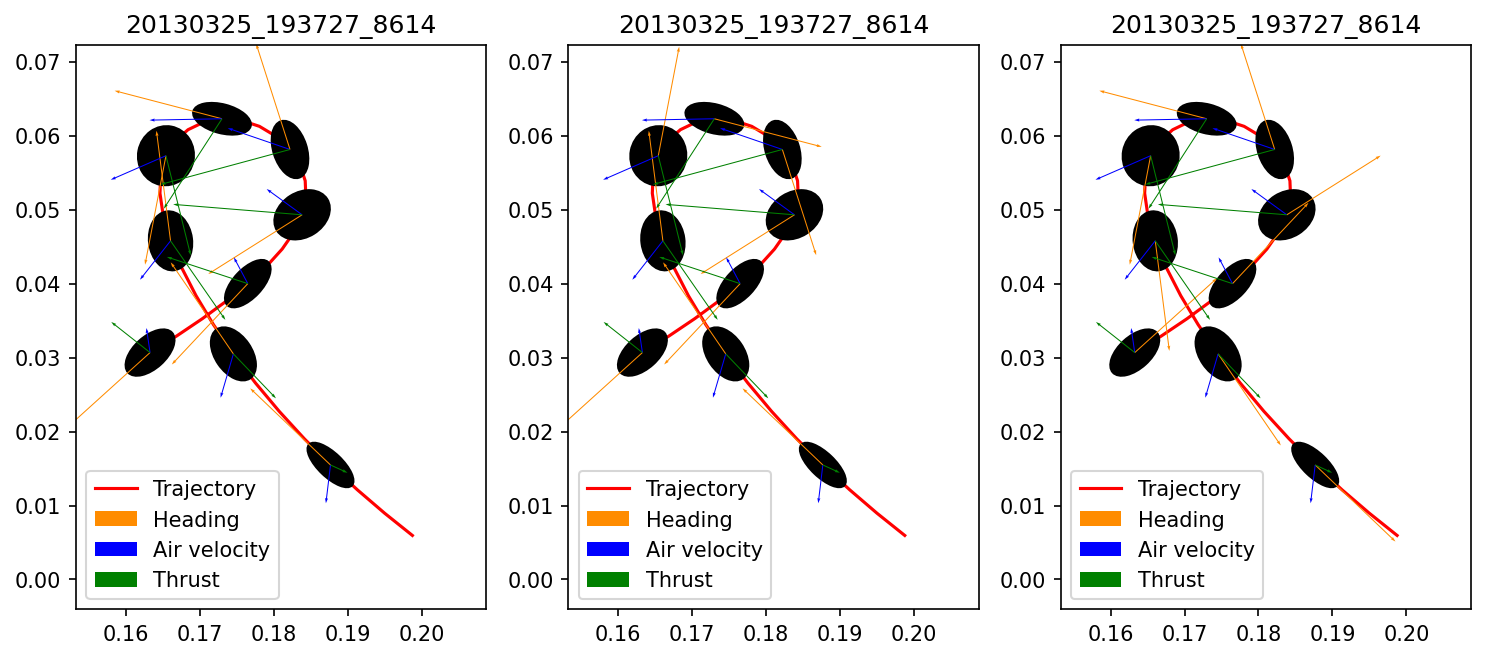

In [7]:
# plot specific trajectory by id
test_trajec = augmented_all_fly_data.loc[augmented_all_fly_data["trajec_objid"]=="20130325_193727_8614"]
fig, axs = plt.subplots(1, 3, figsize=(12, 12), dpi=150)
plot_trajectory(axs[0],test_trajec)
plot_trajectory(axs[1],naive_heading_correction(test_trajec))
plot_trajectory(axs[2],convex_opt_heading_correction(naive_heading_correction(test_trajec)))

### Generate corrected heading for all trajectories
After we are satisfied that the heading is corrected as well as we can, we generate a new heading-and-trajectory dataset with this new heading. 

In [8]:
augmented_all_fly_data = pd.read_csv(f'../ExperimentalData/all_wind_heading_and_trajectories_augmented.csv')
body_and_trajectory_by_id = [group for _, group in augmented_all_fly_data.groupby('trajec_objid')]
temp_dfs = []
for traj in body_and_trajectory_by_id:
    corrected_trajec = convex_opt_heading_correction(naive_heading_correction(traj))
    temp_dfs.append(corrected_trajec)
corrected_aug_all_fly_data = pd.concat(temp_dfs, ignore_index=True)
# Save the combined DataFrame to a new CSV file
corrected_aug_all_fly_data.to_csv('../ExperimentalData/all_wind_heading_and_trajectories_augmented_corrected.csv', index=False)

### Generate filtered trajectories
Inevitably, some trajectories will still have some 180 degree flips we were unable to correct. As we dont wish to train on this messy data, we remove trajectories that have these flips and generate yet another new heading-and-trajectory dataset. The filter metrics are implemented below.

In [9]:
def circular_distance(angle1, angle2):
    """
    Calculate the shortest distance between two angles on a 2D circle.
    
    Parameters:
    angle1, angle2: Angles in radians (can be single values or pandas Series).
    
    Returns:
    float or pd.Series: Shortest distance between the two angles on the circle.
    """
    # Ensure input is a Series
    angle1 = np.asarray(angle1)
    angle2 = np.asarray(angle2)
    
    # Normalize angles to range [0, 2π)
    angle1 = angle1 % (2 * np.pi)
    angle2 = angle2 % (2 * np.pi)
    
    # Calculate the direct distance and the wrapped-around distance
    direct_distance = np.abs(angle1 - angle2)
    wrapped_distance = 2 * np.pi - direct_distance
    
    # Return the shorter of the two distances
    return np.minimum(direct_distance, wrapped_distance)

def calc_circular_difference(trajec: pd.DataFrame) -> list:
    circ_diff_trajec = trajec.copy()
    circ_diff_trajec["circ_dist_diff"] = circular_distance(circ_diff_trajec["heading_angle"],circ_diff_trajec["heading_angle"].shift(1,fill_value=circ_diff_trajec["heading_angle"].iloc[0]))
    return circ_diff_trajec


In [10]:
corrected_aug_all_fly_data = pd.read_csv(f'../ExperimentalData/all_wind_heading_and_trajectories_augmented_corrected.csv')
body_and_trajectory_by_id = [group for _, group in corrected_aug_all_fly_data.groupby('trajec_objid')]
temp_dfs = []
removal_count = 0
for traj in body_and_trajectory_by_id:
   if (max(calc_circular_difference(traj)["circ_dist_diff"]) < np.pi / 2):
      filtered_trajec = traj
      temp_dfs.append(filtered_trajec)
   else:
      removal_count += 1
filtered_corr_aug_all_fly_data = pd.concat(temp_dfs, ignore_index=True)
# Save the combined DataFrame to a new CSV file
filtered_corr_aug_all_fly_data.to_csv('../ExperimentalData/all_wind_heading_and_trajectories_augmented_corrected_filtered.csv', index=False)
print(len(body_and_trajectory_by_id))
print(removal_count)

3339
1312


### Visualize filtered trajectories
For troubleshooting and sanity-check purposes, we generate the plots for all filtered fly trajectories.

In [11]:
filtered_corr_aug_all_fly_data = pd.read_csv(f'../ExperimentalData/all_wind_heading_and_trajectories_augmented_corrected_filtered.csv')
body_and_trajectory_by_id = [group for _, group in filtered_corr_aug_all_fly_data.groupby('trajec_objid')]

In [12]:
import random
import gc

# Set the random seed for repeatability
random.seed(42)

# Randomly sample 100 trajectories from heading_and_trajectory_by_id
sampled_trajectories = random.sample(body_and_trajectory_by_id, 100)

# Loop through each trajectory and create/save figures
for trajectory in sampled_trajectories:
    trajec_objid = trajectory["trajec_objid"].iloc[0]
    fig, ax = plt.subplots(figsize=(12, 12), dpi=150)

    
    plot_trajectory(ax, trajectory)
    
    # Save the figure as an SVG file
    svg_filename = f'../FigurePlots/filtered_trajectory_svgs/{trajec_objid}.svg'
    plt.savefig(svg_filename, format='svg')
    plt.close(fig)  # Close the figure to free up memory
    gc.collect()

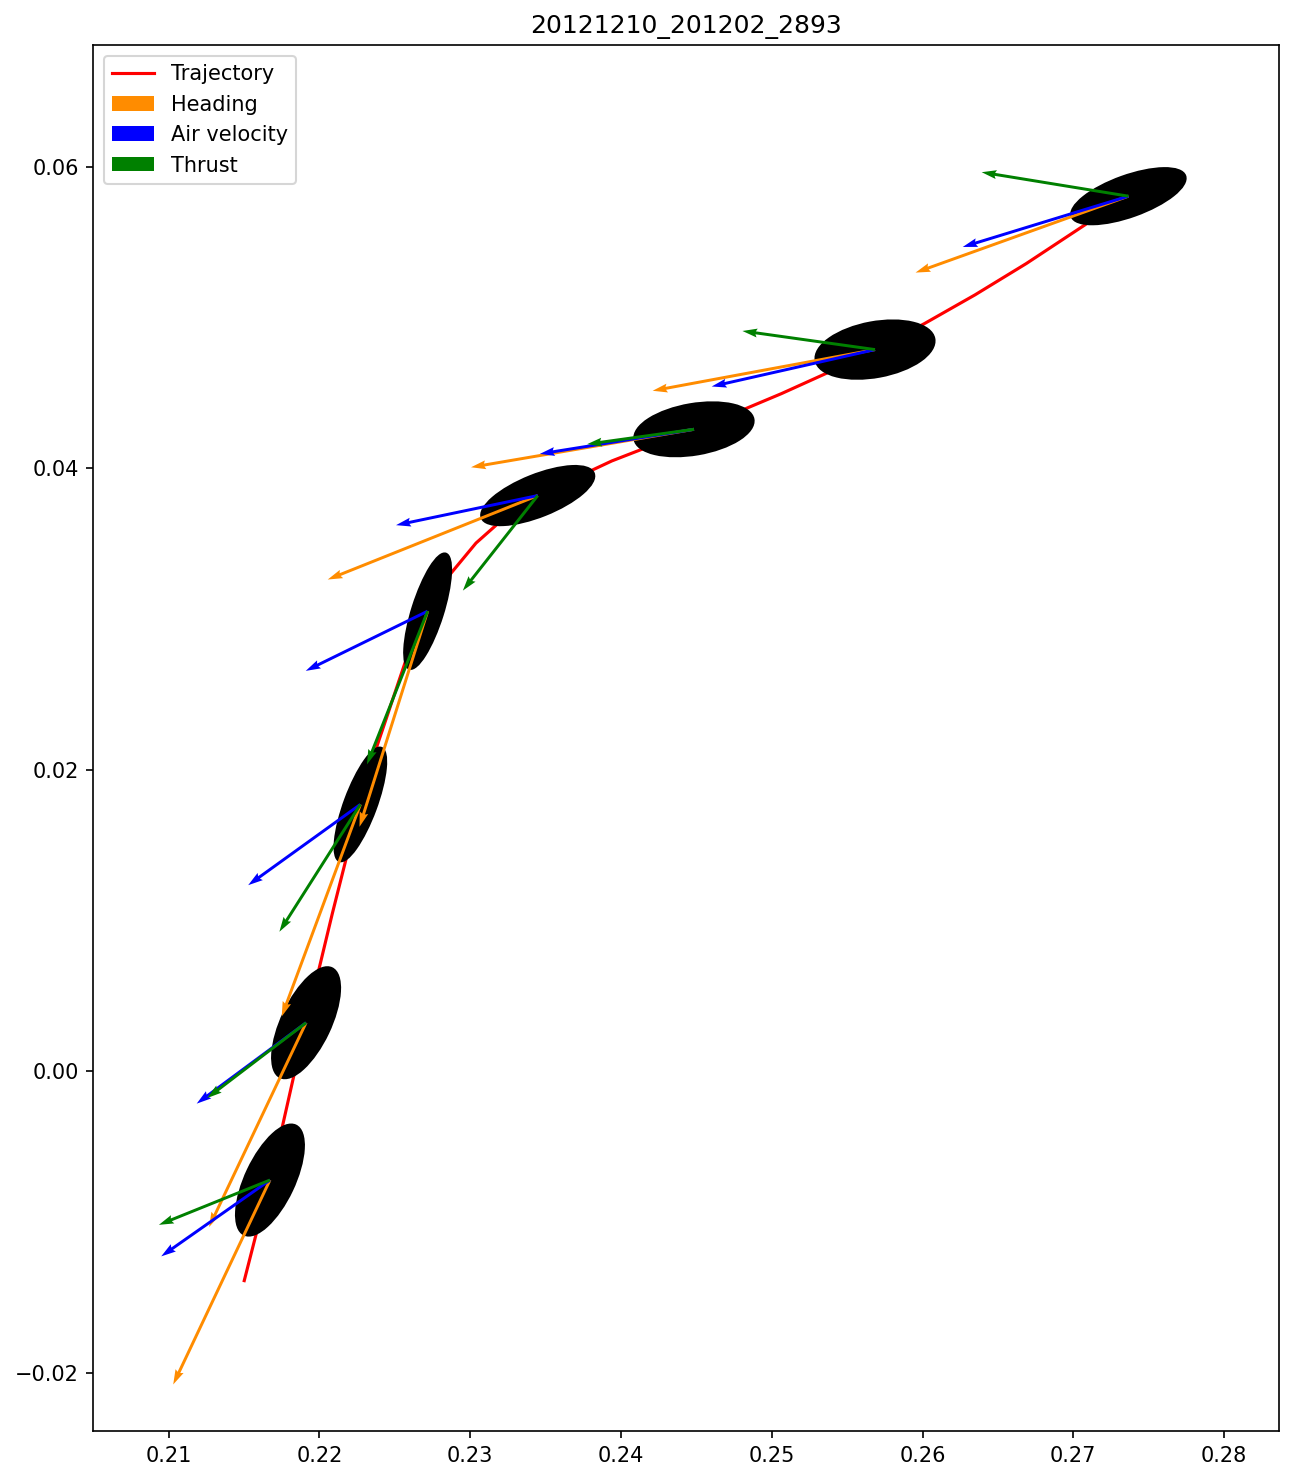

In [13]:
# plot specific trajectory by id
test_trajec = filtered_corr_aug_all_fly_data.loc[filtered_corr_aug_all_fly_data["trajec_objid"]=="20121210_201202_2893"]
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
plot_trajectory(ax,test_trajec)

## Generate Neurel Network

#### Import data
Import the heading-and-trajectory dataset that is filtered and corrected. We augment this data with the additional fields "heading_angle_x" and "heading_angle_y" and save this new augmented data set. 

In [14]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
all_fly_data = pd.read_csv('../ExperimentalData/all_wind_heading_and_trajectories_augmented_corrected_filtered.csv') # import all fly data
all_fly_data['heading_angle_x'] = np.cos(all_fly_data['heading_angle']) # augment df with neurel network output parameters (in this case, to avoid circular-fitting issues)
all_fly_data['heading_angle_y'] = np.sin(all_fly_data['heading_angle'])
all_fly_data.to_csv('../ExperimentalData/all_wind_heading_and_trajectories_augmented_corrected_filtered_headx_heady.csv', index=False)

#### Pull out individual fly trajectories
Pull out all of the fly trajectories into a list for time delay augmentation later. We can choose what minimum length of trajectory we would like to consider as well.

In [15]:
def pull_out_individual_trajectories(all_fly_data: pd.DataFrame, min_traj_length: int = 5) -> list[np.ndarray]:
    """
    Extract individual trajectories from a DataFrame where each trajectory starts with a timestamp of 0.00.
    
    Args:
        all_fly_data (pd.DataFrame): DataFrame containing trajectory data with a 'timestamp' column.
        min_traj_length (int, optional): Minimum number of timesteps required for a trajectory to be included. Default is 5.

    Returns:
        List[np.ndarray]: A list of NumPy arrays, each representing an individual trajectory with more than 'min_traj_length' timesteps.
    """
    
    # Identify indices where new trajectories start (timestamp == 0.00)
    traj_start = np.where(all_fly_data.timestamp.values == 0.00)[0]
    
    # Number of detected trajectories
    n_traj = traj_start.shape[0]
    print(f"Detected {n_traj} trajectories.")
    
    # List to store individual trajectories
    traj_list = []
    
    # Iterate over each trajectory index
    for n in range(n_traj):
        # Determine the end index of the current trajectory
        if n == (n_traj - 1):
            traj_end = all_fly_data.shape[0]  # End of the DataFrame if this is the last trajectory
        else:
            traj_end = traj_start[n + 1]  # Start of the next trajectory
        
        # Extract the trajectory data
        traj = all_fly_data.iloc[traj_start[n]:traj_end, :]
        
        # Check if the trajectory meets the minimum length requirement
        if traj.shape[0] > min_traj_length:
            traj_list.append(traj)  # Convert DataFrame slice to NumPy array
    
    # Report the number of trajectories that meet the length requirement
    print(f"{len(traj_list)} trajectories with more than {min_traj_length} timesteps.")
    
    return traj_list

all_fly_data = pd.read_csv("../ExperimentalData/all_wind_heading_and_trajectories_augmented_corrected_filtered_headx_heady.csv")
# Pull out trajectories above a certain minimum length
fly_traj_list = pull_out_individual_trajectories(all_fly_data,min_traj_length=12)

Detected 2073 trajectories.
2025 trajectories with more than 12 timesteps.


#### Augment data for neurel net
Augment each fly trajectory with time delay embedding. Here the inputs and outputs to the neural net are defined.

In [16]:
def augment_with_time_delay_embedding(fly_traj_list: list[pd.DataFrame],**kwargs):
    def collect_offset_rows(df, aug_column_names=None, keep_column_names=None, w=1, direction='backward'):
        """ Takes a pandas data frame with n rows, list of columns names, and a window size w.
            Then creates an augmented data frame that collects prior or future rows (in window)
            and stacks them as new columns. The augmented data frame will be size (n - w - 1) as the first/last
            w rows do not have enough data before/after them.

            Inputs
                df: pandas data frame
                aug_column_names: names of the columns to augment
                keep_column_names: names of the columns to keep, but not augment
                w: lookback window size (# of rows)
                direction: get the rows from behind ('backward') or front ('forward')

            Outputs
                df_aug: augmented pandas data frame.
                        new columns are named: old_name_0, old_name_1, ... , old_name_w-1
        """

        df = df.reset_index(drop=True)

        # Default for testing
        if df is None:
            df = np.atleast_2d(np.arange(0, 11, 1, dtype=np.double)).T
            df = np.matlib.repmat(df, 1, 4)
            df = pd.DataFrame(df, columns=['a', 'b', 'c', 'd'])
            aug_column_names = ['a', 'b']
        else:  # use the input  values
            # Default is all columns
            if aug_column_names is None:
                aug_column_names = df.columns

        # Make new column names & dictionary to store data
        new_column_names = {}
        df_aug_dict = {}
        for a in aug_column_names:
            new_column_names[a] = []
            df_aug_dict[a] = []

        for a in aug_column_names:  # each augmented column
            for k in range(w):  # each point in lookback window
                new_column_names[a].append(a + '_' + str(k))

        # Augment data
        n_row = df.shape[0]  # # of rows
        n_row_train = n_row - w + 1  # # of rows in augmented data
        for a in aug_column_names:  # each column to augment
            data = df.loc[:, [a]]  # data to augment
            data = np.asmatrix(data)  # as numpy matrix
            df_aug_dict[a] = np.nan * np.ones((n_row_train, len(new_column_names[a])))  # new augmented data matrix

            # Put augmented data in new column, for each column to augment
            for i in range(len(new_column_names[a])):  # each column to augment
                if direction == 'backward':
                    # Start index, starts at the lookback window size & slides up by 1 for each point in window
                    startI = w - 1 - i

                    # End index, starts at end of the matrix &  & slides up by 1 for each point in window
                    endI = n_row - i  # end index, starts at end of matrix &

                elif direction == 'forward':
                    # Start index, starts at the beginning of matrix & slides up down by 1 for each point in window
                    startI = i

                    # End index, starts at end of the matrix minus the window size
                    # & slides down by 1 for each point in window
                    endI = n_row - w + 1 + i  # end index, starts at end of matrix &

                else:
                    raise Exception("direction must be 'forward' or 'backward'")

                # Put augmented data in new column
                df_aug_dict[a][:, i] = np.squeeze(data[startI:endI, :])

            # Convert data to pandas data frame & set new column names
            df_aug_dict[a] = pd.DataFrame(df_aug_dict[a], columns=new_column_names[a])

        # Combine augmented column data
        df_aug = pd.concat(list(df_aug_dict.values()), axis=1)

        # Add non-augmented data, if specified
        if keep_column_names is not None:
            for c in keep_column_names:
                if direction == 'backward':
                    startI = w - 1
                    endI = n_row
                elif direction == 'forward':
                    startI = 0
                    endI = n_row - w
                else:
                    raise Exception("direction must be 'forward' or 'backward'")

                keep = df.loc[startI:endI, [c]].reset_index(drop=True)
                df_aug = pd.concat([df_aug, keep], axis=1)

        return df_aug
    time_window = kwargs["time_window"]
    input_names = kwargs["input_names"]
    output_names = kwargs["output_names"]
    direction = kwargs["direction"]
    traj_augment_list = []
    for traj in fly_traj_list:
        traj_augment = collect_offset_rows(traj,
                                                aug_column_names=input_names,
                                                keep_column_names=output_names,
                                                w=time_window,
                                                direction=direction)

        traj_augment_list.append(traj_augment)

    traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

    return np.round(traj_augment_all, 4)

# It is far more convenient to define these paramters here and pass them as kwargs, as this function will be called several times after here
time_window = 4

input_names = [
    'groundspeed',
    'groundspeed_angle',
    'windspeed',
    'windspeed_angle',
    'airspeed',
    'airspeed_angle',
    'thrust',
    'thrust_angle',
]

output_names = ['heading_angle_x', 'heading_angle_y']

n_input = len(input_names) * time_window
n_output = len(output_names)

print('Inputs:', n_input)
print('Output:', n_output)

time_augmentation_kwargs = {
    "time_window": time_window,
    "input_names": input_names,
    "output_names": output_names,
    "direction": "backward"
}

traj_augment_all = augment_with_time_delay_embedding(fly_traj_list,**time_augmentation_kwargs)

Inputs: 32
Output: 2


#### Train/test split
Set the train/test split.

In [17]:
from sklearn.model_selection import train_test_split
# Input data
X = traj_augment_all.iloc[:, 0:n_input]
# Output data
y = traj_augment_all.iloc[:, n_input:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Fit neurel net
We use a hyperparameter grid search to select for the optimal hyperparameters (e.g. layers, neurons per layer) as we train our neurel net. We then save the best model for later use.

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from functools import partial
from sklearn.model_selection import GridSearchCV

def create_model(n_input, n_output, neurons=50, layers=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=n_input, activation='relu'))
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(n_output, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

model_with_inputs_and_outputs = partial(create_model,n_input=n_input,n_output=n_output)
clf = KerasRegressor(model=model_with_inputs_and_outputs,epochs=150, batch_size=256,validation_split=0.2,layers=1,neurons=20,verbose=0)

# Define hyperparameters to search
param_grid = {
    'neurons': [20, 50, 100],   # Number of neurons
    'layers': [1, 2, 3]         # Number of layers
}

# Set up the grid search
grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Create a DataFrame with the grid search results
df_results = pd.DataFrame(grid_result.cv_results_)

# Print out important columns
print(df_results[['param_layers', 'param_neurons', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Save model weights and architecture
best_estimator = grid.best_estimator_
best_estimator.model_.save('model.keras')


2024-10-21 11:17:13.665130: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 11:17:13.748230: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 11:17:13.801787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 11:17:13.869218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 11:17:13.887368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 11:17:14.064470: I tensorflow/core/platform/cpu_feature_gu

   param_layers  param_neurons  mean_test_score  std_test_score  \
0             1             20        -0.179306        0.005153   
1             1             50        -0.174204        0.005482   
2             1            100        -0.173042        0.005544   
3             2             20        -0.175094        0.004978   
4             2             50        -0.172990        0.004483   
5             2            100        -0.171984        0.003553   
6             3             20        -0.172695        0.006087   
7             3             50        -0.172970        0.007583   
8             3            100        -0.173733        0.007006   

   rank_test_score  
0                9  
1                7  
2                5  
3                8  
4                4  
5                1  
6                2  
7                3  
8                6  


## Generate Figure Plots

In [19]:
import numpy as np
import flydata as fd
import matplotlib.pyplot as plt
import fly_plot_lib_plot as fpl
import figurefirst as fifi
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from keras.models import load_model
best_estimator = load_model('model.keras')
# Define a colormap with a single color
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_cmap', ['blue', 'blue'])
red_cmap = mcolors.LinearSegmentedColormap.from_list('red_cmap', ['red', 'red'])
def plot_trajectory_with_predicted_heading(trajectory: pd.DataFrame, axis: plt.Axes, n_input: int,best_estimator,nskip: int=0,arrow_size=None,include_id=False,plt_show=False,David_data=False,**kwargs):
    def predict_heading_from_fly_trajectory(df: pd.DataFrame, n_input, augment_with_time_delay_embedding: callable, estimator: callable, **kwargs):
        augmented_df = augment_with_time_delay_embedding([df],**kwargs)
        augmented_df = augmented_df.iloc[:, 0:n_input]
        heading_components= estimator.predict(augmented_df)
        heading_angle_predicted = np.arctan2(heading_components[:,1],heading_components[:,0])
        number_of_beginning_time_steps_deleted = len(df["position_x"]) - len(heading_angle_predicted) # obviously, this will not be the beginning time steps if you change the time augmentation to "forward"; similarly, a "center" time augmentation would delete things on both ends

        # Step 1: Extract the first value
        first_value = heading_angle_predicted[0]

        # Step 2: Create an array with the first value repeated 3 times
        prepend_values = np.array([first_value] * number_of_beginning_time_steps_deleted)

        # Step 3: Concatenate the new array with the original array
        new_arr = np.concatenate([prepend_values, heading_angle_predicted])
        return new_arr
    
    def plot_trajectory(xpos, ypos, phi, color, ax=None, size_radius=None, nskip=0,
                colormap='bone_r', colornorm=None, edgecolor='none', reverse=False,alpha=0.7):
        if color is None:
                color = phi

        color = np.array(color)

            #Set size radius
        xymean = np.mean(np.abs(np.hstack((xpos, ypos))))
        if size_radius is None:  # auto set
            xymean = 0.21 * xymean
            if xymean < 0.0001:
                sz = np.array(0.01)
            else:
                sz = np.hstack((xymean, 1))
            size_radius = sz[sz > 0][0]
        else:
            if isinstance(size_radius, list):  # scale default by scalar in list
                xymean = size_radius[0] * xymean
                sz = np.hstack((xymean, 1))
                size_radius = sz[sz > 0][0]
            else:  # use directly
                size_radius = size_radius

        if colornorm is None:
            colornorm = [np.min(color), np.max(color)]

        if reverse:
            xpos = np.flip(xpos, axis=0)
            ypos = np.flip(ypos, axis=0)
            phi = np.flip(phi, axis=0)
            color = np.flip(color, axis=0)

        fpl.colorline_with_heading(ax, np.flip(xpos), np.flip(ypos), np.flip(color, axis=0), np.flip(phi),
                                    nskip=nskip,
                                    size_radius=size_radius,
                                    deg=False,
                                    colormap=colormap,
                                    center_point_size=0.0001,
                                    colornorm=colornorm,
                                    show_centers=False,
                                    size_angle=20,
                                    alpha=alpha,
                                    edgecolor=edgecolor)

        ax.set_aspect('equal')
        
        # Define fixed minimum plot size
        min_size = 0.1  # Adjust this value as needed

        xrange = xpos.max() - xpos.min()
        xrange = np.max([xrange, min_size])
        yrange = ypos.max() - ypos.min()
        yrange = np.max([yrange, min_size])

        ax.set_xlim(xpos.min() - 0.2 * xrange, xpos.max() + 0.2 * xrange)
        ax.set_ylim(ypos.min() - 0.2 * yrange, ypos.max() + 0.2 * yrange)

        if include_id:
            ax.set_title(trajectory['trajec_objid'].iloc[0])
    heading_angle_predicted = predict_heading_from_fly_trajectory(trajectory,n_input,augment_with_time_delay_embedding,best_estimator,**kwargs)

    if David_data is True:
        heading_angle_predicted = heading_angle_predicted + np.pi
    # Plot the predicted heading trajectory first so that it is under the actual trajectory
    plot_trajectory(trajectory.position_x.values,
                    trajectory.position_y.values,
                    heading_angle_predicted, # take different training coordinates into account
                    trajectory.timestamp.values,
                    ax=axis,
                    size_radius=arrow_size,
                    nskip=nskip,
                    colormap=blue_cmap,  
                    colornorm=None,
                    edgecolor='none',
                    reverse=False,
                    alpha=0.7) # Different shade for distinction
    
    # Plot actual trajectory
    plot_trajectory(trajectory.position_x.values,
                    trajectory.position_y.values,
                    trajectory.heading_angle.values,
                    trajectory.timestamp.values,
                    ax=axis,
                    size_radius=arrow_size,
                    nskip=nskip,
                    colormap=red_cmap,
                    colornorm=None,
                    edgecolor="black",
                    reverse=False,
                    alpha=0.3)
    
    

    fifi.mpl_functions.adjust_spines(axis, [])
    if plt_show is True:
        plt.show()

### Visualize Neural Net performance on all data
For troubleshooting and sanity-check purposes, we generate plots showing the predicted vs the actual heading over the course of a trajectory

In [20]:
filtered_corr_aug_all_fly_data = pd.read_csv(f'../ExperimentalData/all_wind_heading_and_trajectories_augmented_corrected_filtered_headx_heady.csv')
body_and_trajectory_by_id = [group for _, group in filtered_corr_aug_all_fly_data.groupby('trajec_objid')]

In [21]:
sampled_trajectories = random.sample(body_and_trajectory_by_id, 100)
# Loop through each trajectory and create/save figures
for trajectory in sampled_trajectories:
    trajec_objid = trajectory["trajec_objid"].iloc[0]
    fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
    plot_trajectory_with_predicted_heading(trajectory,ax,n_input,best_estimator,include_id=True,nskip=4,**time_augmentation_kwargs)
    
    # Save the figure as an SVG file
    svg_filename = f'../FigurePlots/neurel_net_floris_data_svg/{trajec_objid}.svg'
    plt.savefig(svg_filename, format='svg')
    plt.close(fig)  # Close the figure to free up memory
    gc.collect()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


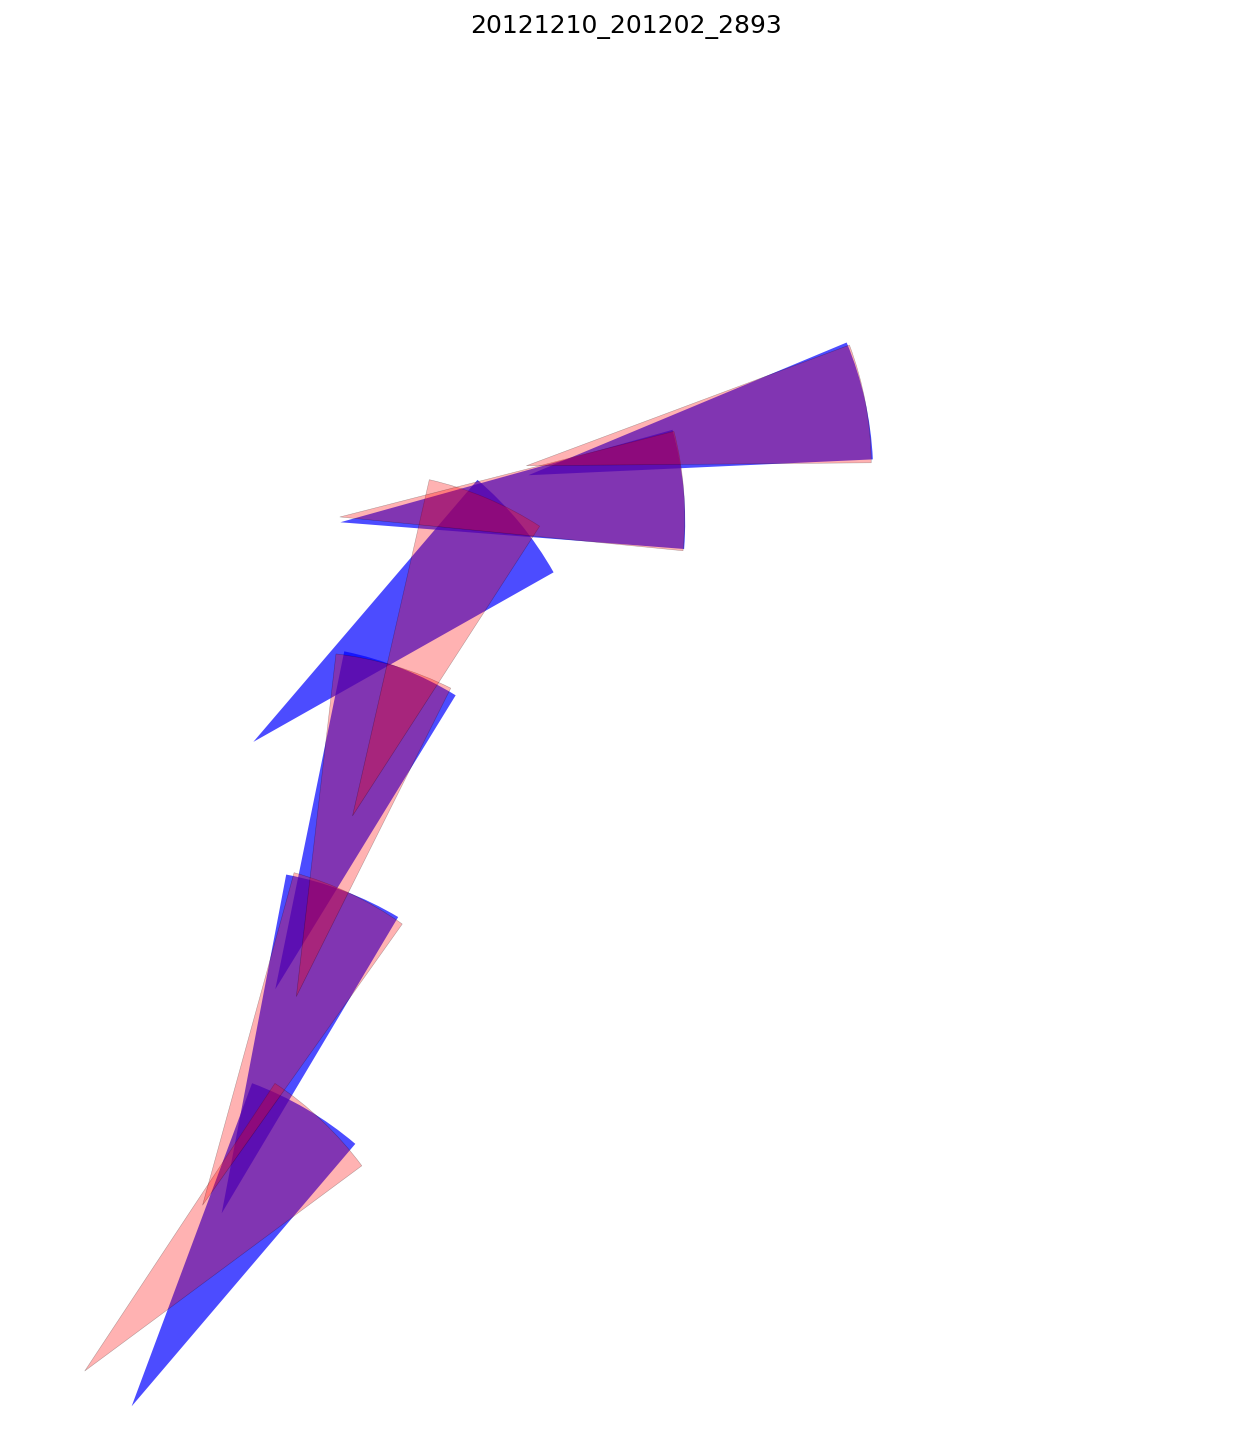

In [22]:
# plot specific trajectory by id
test_trajec = filtered_corr_aug_all_fly_data.loc[filtered_corr_aug_all_fly_data["trajec_objid"]=="20121210_201202_2893"]
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
plot_trajectory_with_predicted_heading(test_trajec,ax,n_input,best_estimator,include_id=True,nskip=4,plt_show=True,**time_augmentation_kwargs)

### Density Plot of Performance
This is a density plot showing the performance of the neurel network on both the training and testing sets

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


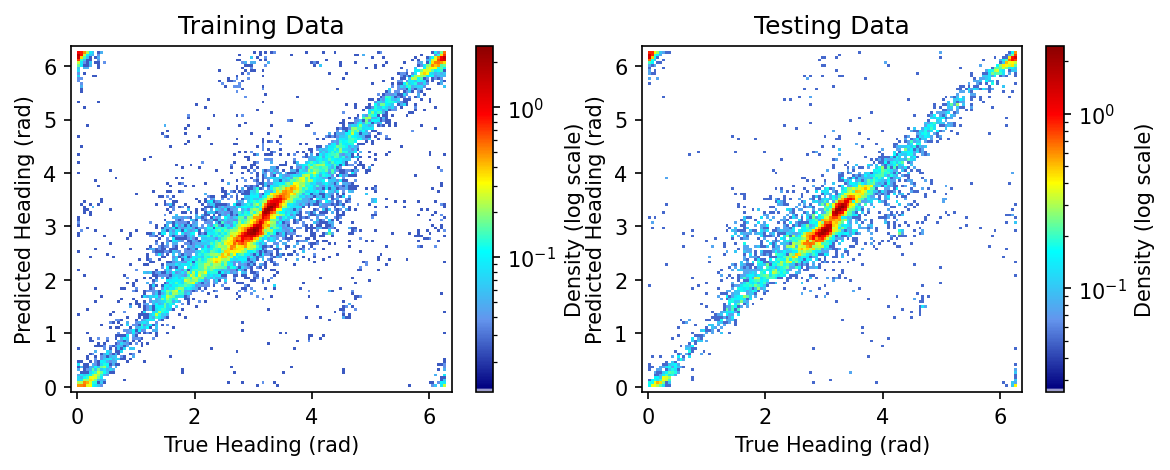

In [23]:
def custom_density_plots(axes: list[plt.Axes], 
                         training_and_testing_X_data: list[np.ndarray], 
                         training_and_testing_y_data: list[np.ndarray], 
                         best_estimator, 
                         cmap,
                         titles: list[str] = ["Training Data", "Testing Data"]) -> None:
    
    for axis, Xdata, ydata, title in zip(axes, training_and_testing_X_data, training_and_testing_y_data, titles):
        # Predict using the best estimator
        Y_predict = best_estimator.predict(Xdata, batch_size=4096)

        # Calculate the predicted and true headings using np.arctan2
        zeta_predict = np.arctan2(Y_predict[:, 1], Y_predict[:, 0])
        zeta_true = np.arctan2(ydata.values[:, 1], ydata.values[:, 0])

        # Wrap the angles to [0, 2*pi)
        zeta_predict = (zeta_predict + 2 * np.pi) % (2 * np.pi)
        zeta_true = (zeta_true + 2 * np.pi) % (2 * np.pi)

        # Create 2D histogram with density normalization and log scale
        h = axis.hist2d(zeta_true, zeta_predict, bins=(128, 128), density=True, cmap=cmap,norm=mcolors.LogNorm(clip=True))
        cbar = plt.colorbar(h[3], ax=axis)
        cbar.set_label('Density (log scale)')

        # Grid and labels
        axis.set_ylim(0 - 0.1, 2 * np.pi + 0.1)
        axis.set_xlim(0 - 0.1, 2 * np.pi + 0.1)
        axis.set_ylabel('Predicted Heading (rad)')
        axis.set_xlabel('True Heading (rad)')
        axis.set_title(title)

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def make_color_map(color_list=None, color_proportions=None, N=256):
    """ Make a colormap from a list of colors.
    """

    if color_list is None:
        color_list = ['white', 'deepskyblue', 'mediumblue', 'yellow', 'orange', 'red', 'darkred']

    if color_proportions is None:
        color_proportions = np.linspace(0.01, 1, len(color_list) - 1)
        v = np.hstack((np.array(0.0), color_proportions))
    elif color_proportions == 'even':
        color_proportions = np.linspace(0.0, 1, len(color_list))
        v = color_proportions

    l = list(zip(v, color_list))
    cmap = LinearSegmentedColormap.from_list('rg', l, N=N)

    return cmap

cmap = make_color_map(color_list=['white', 'navy', 'cornflowerblue', 'aqua', 'yellow', 'red', 'darkred'], N=256)

fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
custom_density_plots([axs[0],axs[1]],[X_train,X_test],[y_train,y_test],best_estimator,cmap,titles=["Training Data", "Testing Data"])

### Visualize Neurel Net performance on David's data
For troubleshooting and sanity-check purposes, we generate plots showing the predicted vs the actual heading over the course of a trajectory from David's data.

In [24]:
# import data and rename fields
temp_fly_data = pd.read_csv('../ExperimentalData/laminar_orco_flash.csv')
temp_fly_data.rename(columns={'obj_id':'trajec_objid','x': 'position_x','y': 'position_y','heading':'heading_angle',"xvel": "velocity_x","yvel": "velocity_y"},inplace=True)

# include only relevant fields
temp_fly_data = temp_fly_data[["trajec_objid", "timestamp", "position_x", "position_y", "velocity_x", "velocity_y","heading_angle"]]


# add necessary fields
temp_fly_data['windspeed'] = 0.4
temp_fly_data['windspeed_angle'] = 0
temp_fly_data['airvelocity_x'] = temp_fly_data['velocity_x'] + 0.4
temp_fly_data['airvelocity_y'] = temp_fly_data['velocity_y'] 
temp_fly_data['heading_angle_x'] = np.cos(temp_fly_data['heading_angle']) 
temp_fly_data['heading_angle_y'] = np.sin(temp_fly_data['heading_angle']) 
# start each merged dataframe at 0, for consistency
def transform_timestamps_to_start_at_zero(fly_trajectory_and_body: pd.DataFrame) -> pd.DataFrame:
    fly_trajectory_and_body["timestamp"] = fly_trajectory_and_body["timestamp"] - fly_trajectory_and_body["timestamp"][0]
    fly_trajectory_and_body["timestamp"] = fly_trajectory_and_body["timestamp"].round(2)
    return fly_trajectory_and_body



# Split the DataFrame into a list of DataFrames based on the 'key' column
temp_fly_data = [group for _, group in temp_fly_data.groupby('trajec_objid')]

# filter trajectories based on length
temp_fly_data = [trajectory for trajectory in temp_fly_data if len(trajectory) > 12]

temp_fly_data = [augment_fly_trajectory(trajectory,compute_heading_from_ellipses=False) for trajectory in temp_fly_data]
David_fly_data = pd.concat(temp_fly_data, ignore_index=True)
David_fly_data.to_csv((f'../ExperimentalData/david_data_augmented.csv'))

In [25]:
David_fly_data = pd.read_csv(f'../ExperimentalData/david_data_augmented.csv')
body_and_trajectory_by_id = [group for _, group in David_fly_data.groupby('trajec_objid')]

In [26]:
sampled_trajectories = random.sample(body_and_trajectory_by_id, 100)
# Loop through each trajectory and create/save figures
for trajectory in sampled_trajectories:
    trajec_objid = trajectory["trajec_objid"].iloc[0]
    fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
    plot_trajectory_with_predicted_heading(trajectory,ax,n_input,best_estimator,include_id=True,nskip=4,David_data=True,**time_augmentation_kwargs)
    
    # Save the figure as an SVG file
    svg_filename = f'../FigurePlots/neurel_net_david_data_svg/{trajec_objid}.svg'
    plt.savefig(svg_filename, format='svg')
    plt.close(fig)  # Close the figure to free up memory
    gc.collect()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


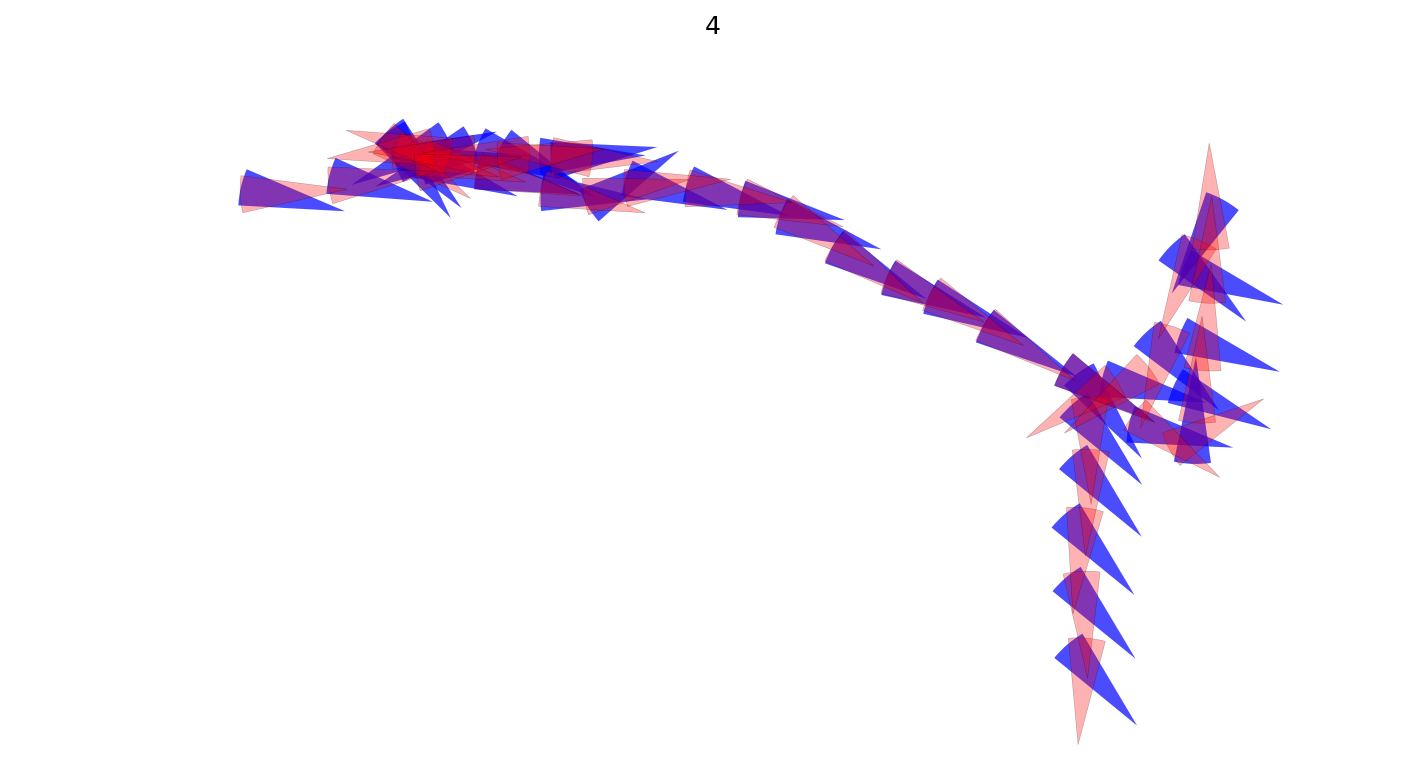

In [35]:
test_trajec = David_fly_data.loc[David_fly_data["trajec_objid"]==4]
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
plot_trajectory_with_predicted_heading(test_trajec,ax,n_input,best_estimator,include_id=True,nskip=4,David_data=True,**time_augmentation_kwargs)

## Ben's Function

In [5]:
import pandas as pd
import numpy as np
David_fly_data = pd.read_csv(f'../ExperimentalData/david_data_augmented.csv')
from keras.models import load_model
best_estimator = load_model('model.keras')
def augment_with_time_delay_embedding(fly_traj_list: list[pd.DataFrame],**kwargs):
    def collect_offset_rows(df, aug_column_names=None, keep_column_names=None, w=1, direction='backward'):
        """ Takes a pandas data frame with n rows, list of columns names, and a window size w.
            Then creates an augmented data frame that collects prior or future rows (in window)
            and stacks them as new columns. The augmented data frame will be size (n - w - 1) as the first/last
            w rows do not have enough data before/after them.

            Inputs
                df: pandas data frame
                aug_column_names: names of the columns to augment
                keep_column_names: names of the columns to keep, but not augment
                w: lookback window size (# of rows)
                direction: get the rows from behind ('backward') or front ('forward')

            Outputs
                df_aug: augmented pandas data frame.
                        new columns are named: old_name_0, old_name_1, ... , old_name_w-1
        """

        df = df.reset_index(drop=True)

        # Default for testing
        if df is None:
            df = np.atleast_2d(np.arange(0, 11, 1, dtype=np.double)).T
            df = np.matlib.repmat(df, 1, 4)
            df = pd.DataFrame(df, columns=['a', 'b', 'c', 'd'])
            aug_column_names = ['a', 'b']
        else:  # use the input  values
            # Default is all columns
            if aug_column_names is None:
                aug_column_names = df.columns

        # Make new column names & dictionary to store data
        new_column_names = {}
        df_aug_dict = {}
        for a in aug_column_names:
            new_column_names[a] = []
            df_aug_dict[a] = []

        for a in aug_column_names:  # each augmented column
            for k in range(w):  # each point in lookback window
                new_column_names[a].append(a + '_' + str(k))

        # Augment data
        n_row = df.shape[0]  # # of rows
        n_row_train = n_row - w + 1  # # of rows in augmented data
        for a in aug_column_names:  # each column to augment
            data = df.loc[:, [a]]  # data to augment
            data = np.asmatrix(data)  # as numpy matrix
            df_aug_dict[a] = np.nan * np.ones((n_row_train, len(new_column_names[a])))  # new augmented data matrix

            # Put augmented data in new column, for each column to augment
            for i in range(len(new_column_names[a])):  # each column to augment
                if direction == 'backward':
                    # Start index, starts at the lookback window size & slides up by 1 for each point in window
                    startI = w - 1 - i

                    # End index, starts at end of the matrix &  & slides up by 1 for each point in window
                    endI = n_row - i  # end index, starts at end of matrix &

                elif direction == 'forward':
                    # Start index, starts at the beginning of matrix & slides up down by 1 for each point in window
                    startI = i

                    # End index, starts at end of the matrix minus the window size
                    # & slides down by 1 for each point in window
                    endI = n_row - w + 1 + i  # end index, starts at end of matrix &

                else:
                    raise Exception("direction must be 'forward' or 'backward'")

                # Put augmented data in new column
                df_aug_dict[a][:, i] = np.squeeze(data[startI:endI, :])

            # Convert data to pandas data frame & set new column names
            df_aug_dict[a] = pd.DataFrame(df_aug_dict[a], columns=new_column_names[a])

        # Combine augmented column data
        df_aug = pd.concat(list(df_aug_dict.values()), axis=1)

        # Add non-augmented data, if specified
        if keep_column_names is not None:
            for c in keep_column_names:
                if direction == 'backward':
                    startI = w - 1
                    endI = n_row
                elif direction == 'forward':
                    startI = 0
                    endI = n_row - w
                else:
                    raise Exception("direction must be 'forward' or 'backward'")

                keep = df.loc[startI:endI, [c]].reset_index(drop=True)
                df_aug = pd.concat([df_aug, keep], axis=1)

        return df_aug
    time_window = kwargs["time_window"]
    input_names = kwargs["input_names"]
    output_names = kwargs["output_names"]
    direction = kwargs["direction"]
    traj_augment_list = []
    for traj in fly_traj_list:
        traj_augment = collect_offset_rows(traj,
                                                aug_column_names=input_names,
                                                keep_column_names=output_names,
                                                w=time_window,
                                                direction=direction)

        traj_augment_list.append(traj_augment)

    traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

    return np.round(traj_augment_all, 4)

def predict_heading_from_fly_trajectory(df: pd.DataFrame, n_input, augment_with_time_delay_embedding: callable, estimator: callable, **kwargs):
    augmented_df = augment_with_time_delay_embedding([df],**kwargs)
    augmented_df = augmented_df.iloc[:, 0:n_input]
    heading_components= estimator.predict(augmented_df)
    heading_angle_predicted = np.arctan2(heading_components[:,1],heading_components[:,0])
    number_of_beginning_time_steps_deleted = len(df["position_x"]) - len(heading_angle_predicted) # obviously, this will not be the beginning time steps if you change the time augmentation to "forward"; similarly, a "center" time augmentation would delete things on both ends

    # Step 1: Extract the first value
    first_value = heading_angle_predicted[0]

    # Step 2: Create an array with the first value repeated 3 times
    prepend_values = np.array([first_value] * number_of_beginning_time_steps_deleted)

    # Step 3: Concatenate the new array with the original array
    heading_angle_predicted_arr = np.concatenate([prepend_values, heading_angle_predicted])
    return heading_angle_predicted_arr

# It is far more convenient to define these parameters here and pass them as kwargs, as this function may be modified in the future
time_window = 4

input_names = [
    'groundspeed',
    'groundspeed_angle',
    'windspeed',
    'windspeed_angle',
    'airspeed',
    'airspeed_angle',
    'thrust',
    'thrust_angle',
]

output_names = ['heading_angle_x', 'heading_angle_y']

n_input = len(input_names) * time_window
n_output = len(output_names)

time_augmentation_kwargs = {
    "time_window": time_window,
    "input_names": input_names,
    "output_names": output_names,
    "direction": "backward"
}

# this one-liner will return an array of predicted headings
test_trajec = David_fly_data.loc[David_fly_data["trajec_objid"]==4]
predict_heading_from_fly_trajectory(test_trajec,n_input,augment_with_time_delay_embedding,best_estimator,**time_augmentation_kwargs)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([ 2.9124546 ,  2.9124546 ,  2.9124546 ,  2.9124546 ,  2.9171724 ,
        2.9060507 ,  2.906797  ,  2.9019935 ,  2.8926826 ,  2.878059  ,
        2.8600242 ,  2.8287292 ,  2.8034189 ,  2.7907753 ,  2.779191  ,
        2.775415  ,  2.7488437 ,  2.685884  ,  2.6349478 ,  2.5792658 ,
        2.6457517 ,  2.9400976 , -3.123999  , -3.012471  , -2.986083  ,
       -3.0643458 , -2.0756032 , -3.082555  , -3.1327622 , -2.918364  ,
        2.714648  ,  2.7714562 ,  2.7836342 ,  2.7890608 ,  2.8139045 ,
        2.4619632 ,  0.476495  ,  0.40969387,  0.42407855,  0.4530927 ,
        0.44745383,  0.43615445,  0.44370225,  0.4499352 ,  0.45705858,
        0.44574907,  0.42236778,  1.861076  ,  2.3240435 ,  1.7238743 ,
        2.10298   ,  2.0903459 ,  2.0796952 ,  2.1887856 ,  2.4437814 ,
        2.7299135 , -2.9564495 , -2.8148048 , -2.8238487 , -2.8351226 ,
       -2.9025314 , -2.9089155 , -2.9907043 , -3.0358474 , -3.0743613 ,
        3.1311746 ,  3.0541503 ,  2.9688444 ,  2.9182286 ,  2.88